In [1]:
from kafka import KafkaConsumer

import pandas as pd
import re
import pickle

In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=True, 
    group_id=None
)

### Converting messages to Dataframe:
    
    PPreprocessing function - Refines the message.value to string and it is cleaned to remove unnecessary characters. The final string is stripped into a list of records. 
    
    create_dataframe - Fetches the list of records in chunk sizes of 1000 and returns a data frame. For early first record of column names is removed from the data frame to use as columns. 

In [3]:
def processing(msg):
    
    # decode extacts the msg value as string
    message = msg.value.decode('utf8')
    
    # cleaning message 
    message = message.replace('\\n', '')
    message = message.replace('"', '')
    
    #coverting message to list to append in dataframe
    message = list(message.split(","))
    
    return message
    
    
column_names = ['timestamp','FQDN_count','subdomain_length','upper','lower','numeric',
           'entropy','special','labels','labels_max','labels_average','longest_word','sld','len','subdomain','Target Attack']

    
def create_dataframe(records):
    
    data = pd.DataFrame(records,columns = column_names)
    
    if ('time' in data['timestamp'].iloc[0]):
        
        # Drop first row by selecting all rows from first row onwards
        data = data.iloc[1: , :]
        
    return data

### Data preprocessing:
    
    cleaning_data - Converts the timestamp feature into float64 type by changing timestamp to seconds. 
    Hash function on Mixed type columns 'sld' and 'longest_word' by applying hash on each value in the features. 

    

In [4]:
#Converting time stamp to numerical feature

def get_sec(time_str,col):
    """Get seconds from time."""
    m, s  = time_str[col].split(':')
    
    return float(m) * 60 + float(s)

In [5]:
def cleaning_data(data):
    
    #Converting time stamp
    
    data['timestamp'] = data.apply(lambda row: get_sec(row, 'timestamp'),axis=1)
    
    # Encode our string using UTF-8 default 

    data['sld'] = data['sld'].apply(hash)
    data['longest_word'] = data['longest_word'].apply(hash)
    
    return data


### Evaluation metrics:
    
    Accuracy - simple intuitive metric for performance calculation, but fails on skewed class distribution.
    
    F1_score - combines precision and recall, espicially to give more attenstion of positives.
    
    auc_precision_recall - gives better look for misclassification of minority classes in case of class imbalance.
    

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def metrics(mdl,X,y_test):
    
    #predictions
    predicted = mdl.predict(X)
    
    #Acccuracy score
    acc = accuracy_score(y_test, predicted)
    
    # Weighted f1-score - to contain imbalance
    f1 = f1_score(y_test, predicted, average='weighted')
    
    # Data to precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, predicted)
    
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
     
    return acc,f1,auc_precision_recall
    
    

### Model-Training:
    
    Step 1 - Loads saved model twice as Static and Dynamic model.
    
    Step 2 - cleans the data, seperates predicting and target features. Performs Featues-selection using selected features from static model.
    
    Step 3 - Standadize features by standardscalar features sclaing
    
    Step 4 - Evaluates both models on the final data.
    
    Step 5 - Retrains the models that met the threshold for decision.
    
    Deacay - When the sample's f1-score falls below a certain level (in this case, 0.81) and suc score to 0.88, it starts a re-train the task with current 1000 samples of records.
    

In [7]:
df_data = pd.DataFrame()
# Feature Scaling

accuracy_sm = []
F1_score_sm = []
auc_score_sm = []

accuracy_dm = []
F1_score_dm = []
auc_score_dm = []

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

#load the saved static model
Static_model = pickle.load(open("model_NN.pkl", "rb"))

model = pickle.load(open("model_NN.pkl", "rb"))

def model_training(df):
    
    #clean the dataframe
    data = cleaning_data(df)
    #df_data.append(data)
    
    # Declare feature vector and target variable
    X = data.drop(['Target Attack'], axis = 1)
    y = data['Target Attack'].astype(int)
    
    
    #load the selected featues in static model
    selected_features = pickle.load(open("features_selected.pkl", "rb"))
    

    # Extracting the dataset with only columns from Feature selection output
    X_train = X[selected_features]
    
    #feature scaling  
    X_train_scaled = sc.fit_transform(X_train)
    
    #evaluate the model on data
    accuracy_s, f1_score_S, auc_s = metrics(Static_model,X_train_scaled,y)
    accuracy_sm.append(accuracy_s)
    F1_score_sm.append(f1_score_S)
    auc_score_sm.append(auc_s)
    
    #decision to retrain the model on data - threashold set based on static model output
    accuracy, f1_score, auc = metrics(model,X_train_scaled,y)
    accuracy_dm.append(accuracy)
    F1_score_dm.append(f1_score)
    auc_score_dm.append(auc)
    
    if(f1_score < 0.81 or auc <0.88):
        
        #retrain the model
        model.partial_fit(X_train_scaled, y)
        print("predicting....")
    
    

    
    

### Collect data:
    
    CConsumer loop that continually invokes the poll function to get data one at a time that has been effectively pre-fetched by the consumer in the background. Uses the subscribe method to define which topics should be fetched from before starting the consumer loop. Each record is processed to extract the message value. For every 1000 clean records that are appended in the empty list, it creates a dataframe and invokes the model_training.

In [8]:
consumer.subscribe('ml-raw-dns')    

while True:
    records = consumer.poll(max_records = 1000)
    # Retrieve the message and the key

    record_list = []
    
    for tp, consumer_records in records.items():
            for consumer_record in consumer_records:
                
                # cleaning message value
                msg = processing(consumer_record)
                
                record_list.append(msg)
            
            #creating dataframe for every thousand records
            df = create_dataframe(record_list)
            model_training(df)
                     

predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting....
predicting

KeyboardInterrupt: 

### Results of static model

Plots the evaluations on both models for each metrics.

As illustrated below the dynamic model is clearly have better or same performance on each window of 1000 observations than that of static model.

In [9]:
import matplotlib.pyplot as plt

def plot(sm,dm):
    
    #constructing dataframe of results
    data = {'static': sm, 'dynamic':dm}
    
    results= pd.DataFrame(data,)
    results['window'] = results.index
    
    # multiple line plots
    plt.figure(figsize=(15, 7))
    plt.plot( 'window', 'static', data=results, marker='', linewidth=1.2)
    plt.plot( 'window', 'dynamic', data=results, marker='', color='olive', linewidth=1.2)    
    # show legend
    plt.legend()

    # show graph
    plt.show()

##### visualization the f1-score metrics

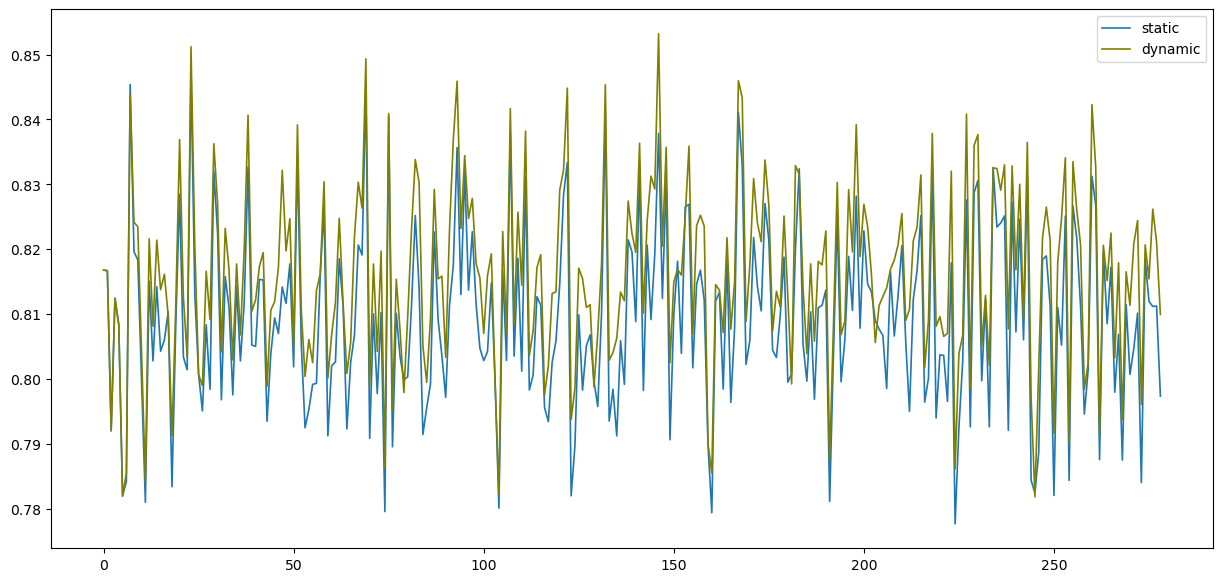

In [10]:
#visualization the f1-score metrics

res = plot(F1_score_sm, F1_score_dm)


##### visualization the accuracy metrics

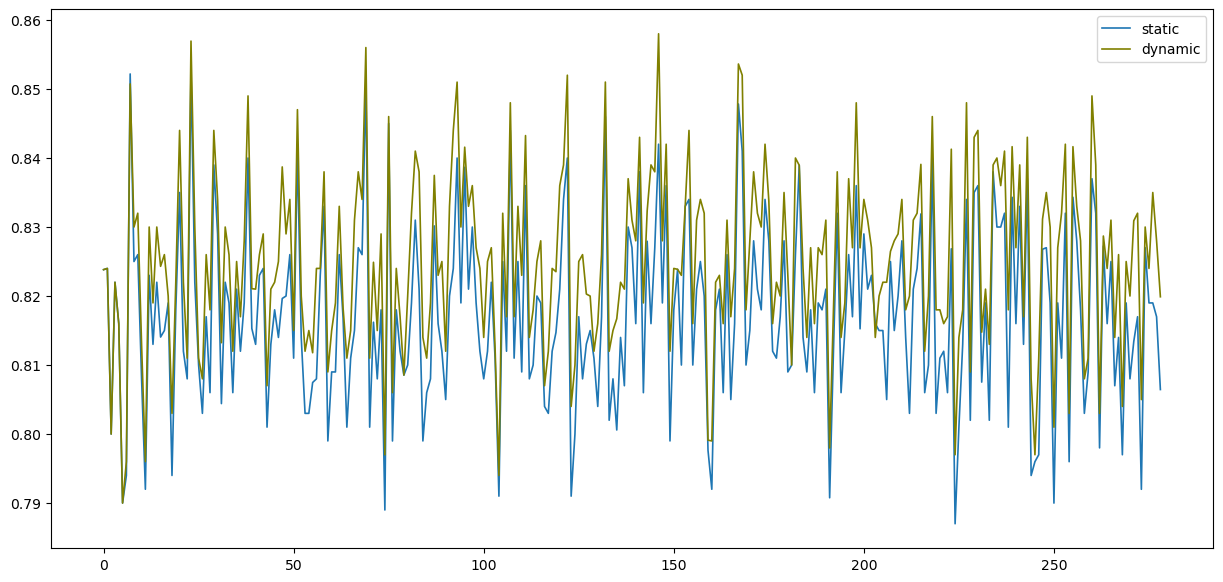

In [11]:
#Visualization the accuracy metrics

plot(accuracy_sm, accuracy_dm)

##### visualization the precision recall score metrics

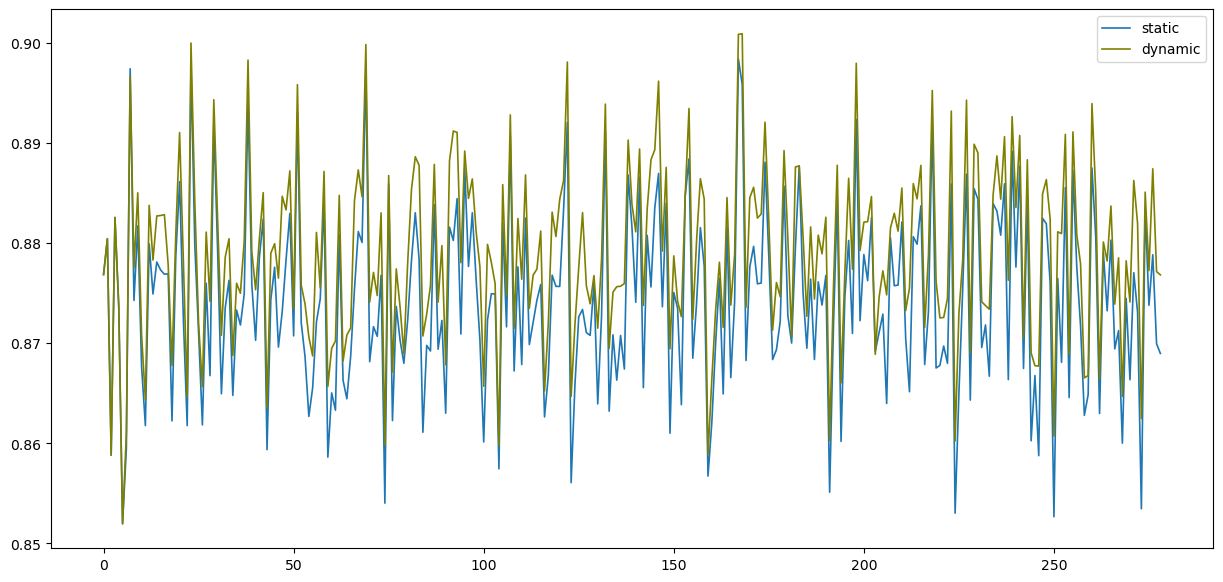

In [12]:
#visualization the precision recall score metrics

plot(auc_score_sm, auc_score_dm)